# GAN for dataset
This notebook is for using Gan and then TSTR fitting data using Random forest classifier, ROC

In [9]:
!pip install catboost
!pip install ctgan

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: C:\Users\isund\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: C:\Users\isund\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [10]:
from ctgan import CTGAN
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

import gc
import numpy as np
import pandas as pd

In [11]:
#Load and prepare data
df = pd.read_parquet("NIDS_DF_processed.parquet")

print("Full DF shape:", df.shape)
print(df['Attack'].value_counts().head())
print(df.info())

# Build smaller balanced-ish dataset with max 870 rows per attack type
k = 870  # max rows per Attack type

small_df = (
    df
    .groupby("Attack", group_keys=False)
    .apply(lambda g: g.sample(
        n=min(len(g), k),
        random_state=42
    ))
).reset_index(drop=True)

print("small_df shape:", small_df.shape)
print(small_df['Attack'].value_counts())
print(small_df['Label'].value_counts())


Full DF shape: (9156325, 13)
Attack
Benign            7168119
Reconnaissance     478047
injection          460848
DDoS               305588
DoS                248964
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9156325 entries, 0 to 9156324
Data columns (total 13 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   L4_SRC_PORT                 int32  
 1   L4_DST_PORT                 int32  
 2   PROTOCOL                    int16  
 3   L7_PROTO                    float32
 4   IN_BYTES                    int32  
 5   OUT_BYTES                   int32  
 6   IN_PKTS                     int32  
 7   OUT_PKTS                    int32  
 8   TCP_FLAGS                   int16  
 9   FLOW_DURATION_MILLISECONDS  int32  
 10  Label                       int8   
 11  Attack                      object 
 12  Attack_int                  int64  
dtypes: float32(1), int16(2), int32(7), int64(1), int8(1), object(1)
memory usag

C:\Users\isund\AppData\Local\Temp\ipykernel_16876\3829628471.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(


In [12]:
leak_cols = ['Attack', 'Attack_int', 'Label']

X_base = small_df.drop(columns=[c for c in leak_cols if c in small_df.columns])
y_base = small_df['Label']

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X_base,
    y_base,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

In [13]:

print("Potential leak columns in X_train_base:",
      [c for c in X_train_base.columns if 'attack' in c.lower() or 'label' in c.lower()])

baseline_model = CatBoostClassifier(
    depth=8,
    learning_rate=0.1,
    loss_function='Logloss',
    eval_metric='Accuracy',
    verbose=False,
    random_state=42
)

baseline_model.fit(X_train_base, y_train_base)

y_pred_base = baseline_model.predict(X_test_base)

print("=== Baseline (no CTGAN) ===")
print("Accuracy:", accuracy_score(y_test_base, y_pred_base))
print(classification_report(y_test_base, y_pred_base))

Potential leak columns in X_train_base: []
=== Baseline (no CTGAN) ===
Accuracy: 0.9674017257909875
              precision    recall  f1-score   support

           0       0.72      0.60      0.65       214
           1       0.98      0.99      0.98      3958

    accuracy                           0.97      4172
   macro avg       0.85      0.79      0.82      4172
weighted avg       0.97      0.97      0.97      4172



# GAN

In [14]:
attacks_only = small_df.query("Label == 1").copy()

print("Attacks_only shape:", attacks_only.shape)
print(attacks_only['Attack'].value_counts())

Attacks_only shape: (15816, 13)
Attack
Backdoor          870
Bot               870
Brute Force       870
DDoS              870
Theft             870
DoS               870
Exploits          870
Fuzzers           870
Generic           870
Infilteration     870
Reconnaissance    870
Shellcode         870
xss               870
injection         870
mitm              870
password          870
scanning          870
Analysis          731
Worms             153
ransomware        142
Name: count, dtype: int64


In [15]:
# Drop Label for CTGAN input (CTGAN is not a classifier)
ctgan_train = attacks_only.drop(columns=['Label'])

# Treat these as discrete for CTGAN
discrete_cols = ['Attack', 'Attack_int', 'PROTOCOL', 'TCP_FLAGS', 'L7_PROTO']

print("CTGAN training columns:", ctgan_train.columns.tolist())
print("CTGAN discrete columns:", discrete_cols)

CTGAN training columns: ['L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS', 'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'Attack', 'Attack_int']
CTGAN discrete columns: ['Attack', 'Attack_int', 'PROTOCOL', 'TCP_FLAGS', 'L7_PROTO']


In [20]:
# Ensure all discrete columns are present and categorical/object dtype
for col in discrete_cols:
    if col in ctgan_train.columns:
        ctgan_train[col] = ctgan_train[col].astype("category")

ctgan = CTGAN(
    epochs=100,       # you can tune this
    batch_size=256,    # smaller batch for RAM
    pac =1 
)

ctgan.fit(
    ctgan_train,
    discrete_columns=discrete_cols
)
#editted for minority class being 

                        

In [21]:
n_synth = 20000  # adjust as you like
synthetic_df = ctgan.sample(n_synth)

# Make sure we have same feature columns as ctgan_train (no Label yet)
synthetic_df = synthetic_df[ctgan_train.columns]

# Add Label = 1
synthetic_df['Label'] = 1

print("Synthetic_df shape:", synthetic_df.shape)
print("Synthetic preview:")
print(synthetic_df.head())
print("\nSynthetic Label distribution:")
print(synthetic_df['Label'].value_counts(normalize=True))

Synthetic_df shape: (20000, 13)
Synthetic preview:
   L4_SRC_PORT  L4_DST_PORT PROTOCOL   L7_PROTO  IN_BYTES  OUT_BYTES  IN_PKTS  \
0         1444            0        5   0.000000       329      -1384       10   
1        35358          170        6   5.120000      1720       4692       11   
2        50199          461        6  91.125999       341      -5622        4   
3        45467          226        6   7.000000       925         55        6   
4         9790        15161       17   0.000000      1076      -1135        6   

   OUT_PKTS TCP_FLAGS  FLOW_DURATION_MILLISECONDS         Attack Attack_int  \
0        -2         0                        -150       Backdoor          6   
1         4        27                        -845           mitm          4   
2         0        24                     4274828  Infilteration         17   
3         5        27                         350           DDoS         11   
4         1         0                        1830      Shellcode   

In [22]:
# Clip invalid negatives in numeric columns
num_cols_to_clip = [
    'L4_SRC_PORT', 'L4_DST_PORT',
    'IN_BYTES', 'OUT_BYTES',
    'IN_PKTS', 'OUT_PKTS',
    'FLOW_DURATION_MILLISECONDS'
]

for col in num_cols_to_clip:
    if col in synthetic_df.columns:
        synthetic_df[col] = synthetic_df[col].clip(lower=0)

print("\nSynthetic numeric summary after clipping:")
print(synthetic_df[num_cols_to_clip].describe())



Synthetic numeric summary after clipping:
        L4_SRC_PORT   L4_DST_PORT       IN_BYTES      OUT_BYTES       IN_PKTS  \
count  20000.000000  20000.000000   20000.000000   20000.000000  20000.000000   
mean   35604.774050   2227.840550    2168.503700    3304.411000     13.580300   
std    22911.861812   7477.724525    8462.860355   27747.183265     27.726087   
min        0.000000      0.000000       0.000000       0.000000      0.000000   
25%     6879.000000     11.000000     245.750000       0.000000      4.000000   
50%    41065.000000     86.000000     586.000000       0.000000      7.000000   
75%    56690.000000    416.000000    1140.000000     239.250000     13.000000   
max    67977.000000  68485.000000  109062.000000  480781.000000    326.000000   

           OUT_PKTS  FLOW_DURATION_MILLISECONDS  
count  20000.000000                2.000000e+04  
mean       6.033800                8.741539e+05  
std       15.716078                1.723744e+06  
min        0.000000        

In [23]:
training_data, test_data = train_test_split(
    small_df,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

print("Training_data shape:", training_data.shape)
print("Test_data shape:", test_data.shape)
print("Training Label distribution:\n", training_data['Label'].value_counts())
print("Test Label distribution:\n", test_data['Label'].value_counts())


Training_data shape: (12514, 13)
Test_data shape: (4172, 13)
Training Label distribution:
 Label
1    11858
0      656
Name: count, dtype: int64
Test Label distribution:
 Label
1    3958
0     214
Name: count, dtype: int64


In [24]:
# Real benign flows from training_data
real_benign_train = training_data.query("Label == 0").copy()
print("Real benign in training_data:", len(real_benign_train))

# Align synthetic columns with training_data (without dropping Attack yet)
feature_cols_with_attack = training_data.drop(columns=['Label']).columns
synthetic_df = synthetic_df[feature_cols_with_attack.tolist() + ['Label']]

print("Synthetic_df columns:", synthetic_df.columns)

# Concatenate: real benign + synthetic attacks
train_synthetic = pd.concat(
    [real_benign_train, synthetic_df],
    ignore_index=True
)

print("=== train_synthetic Label counts ===")
print(train_synthetic['Label'].value_counts())
print("\n=== train_synthetic Attack counts (top 10) ===")
print(train_synthetic['Attack'].value_counts().head(10))


Real benign in training_data: 656
Synthetic_df columns: Index(['L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'IN_BYTES',
       'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS', 'TCP_FLAGS',
       'FLOW_DURATION_MILLISECONDS', 'Attack', 'Attack_int', 'Label'],
      dtype='object')
=== train_synthetic Label counts ===
Label
1    20000
0      656
Name: count, dtype: int64

=== train_synthetic Attack counts (top 10) ===
Attack
Analysis          3468
Generic           1718
mitm              1662
Infilteration     1647
Exploits          1092
Fuzzers           1091
DDoS              1006
Theft              985
Reconnaissance     844
Bot                806
Name: count, dtype: int64


In [25]:
leak_cols = ['Attack', 'Attack_int', 'Label']

# TRAIN (augmented): real benign + synthetic attacks
X_train_syn = train_synthetic.drop(columns=[c for c in leak_cols if c in train_synthetic.columns])
y_train_syn = train_synthetic['Label']

# TEST (real-only): from test_data
X_test_syn = test_data.drop(columns=[c for c in leak_cols if c in test_data.columns])
y_test_syn = test_data['Label']

print("X_train_syn shape:", X_train_syn.shape)
print("X_test_syn shape:", X_test_syn.shape)

print("Potential leak columns in X_train_syn:",
      [c for c in X_train_syn.columns if 'attack' in c.lower() or 'label' in c.lower()])


X_train_syn shape: (20656, 10)
X_test_syn shape: (4172, 10)
Potential leak columns in X_train_syn: []


In [27]:

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_base),
    y=y_train_base
)

print("Class weights:", class_weights)


Class weights: [9.53810976 0.52766065]


In [28]:
ctb = CatBoostClassifier(
    depth=8,
    learning_rate=0.1,
    loss_function='Logloss',
    eval_metric='Accuracy',
    verbose=False,
    random_state=42,
    class_weights=class_weights
)

ctb.fit(X_train_base, y_train_base)
y_pred_base2 = ctb.predict(X_test_base)

print("Improved Baseline Accuracy:", accuracy_score(y_test_base, y_pred_base2))
print(classification_report(y_test_base, y_pred_base2))


Improved Baseline Accuracy: 0.961169702780441
              precision    recall  f1-score   support

           0       0.58      0.87      0.70       214
           1       0.99      0.97      0.98      3958

    accuracy                           0.96      4172
   macro avg       0.79      0.92      0.84      4172
weighted avg       0.97      0.96      0.96      4172



In [30]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# --- Save summary table as PNG ---
# results_df is expected to exist in the notebook
table_df = results_df.fillna("NA").round(4).astype(str)

n_rows, n_cols = table_df.shape
fig_w = max(6, n_cols * 1.2)
fig_h = max(1.5, (n_rows + 1) * 0.5)

fig, ax = plt.subplots(figsize=(fig_w, fig_h))
ax.axis("off")
tbl = ax.table(
    cellText=table_df.values,
    colLabels=table_df.columns.tolist(),
    rowLabels=table_df.index.tolist(),
    cellLoc="center",
    loc="center"
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.2)
plt.title("Model comparison summary", fontsize=12)
plt.savefig("results_table.png", dpi=300, bbox_inches="tight")
plt.close(fig)

print("Saved summary table to results_table.png")

# --- Save classification reports as PNG ---
# Build a single multi-line string with all reports
report_texts = []
for name, model, X_test, y_true, y_pred in models_to_eval:
    if y_pred is None and model is not None:
        y_pred = model.predict(X_test)
    rpt = classification_report(y_true, y_pred, zero_division=0)
    header = f"=== Classification report: {name} ==="
    report_texts.append(header)
    report_texts.append(rpt)

full_text = "\n\n".join(report_texts)

# Render text onto a figure
lines = full_text.splitlines()
# estimate figure size: width fixed, height per line
char_width = 0.012  # rough char width in inches
max_line_len = max(len(l) for l in lines) if lines else 80
fig_w = max(8, max_line_len * char_width)
fig_h = max(2, len(lines) * 0.18)

fig, ax = plt.subplots(figsize=(fig_w, fig_h))
ax.axis("off")
# monospace for alignment
ax.text(0, 1, full_text, va="top", ha="left", fontfamily="monospace", fontsize=9)
plt.savefig("classification_reports.png", dpi=300, bbox_inches="tight")
plt.close(fig)

print("Saved classification reports to classification_reports.png")


Saved summary table to results_table.png
Saved classification reports to classification_reports.png


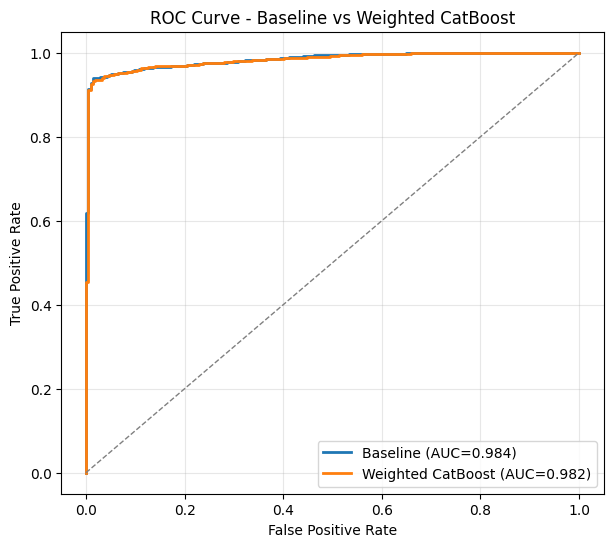

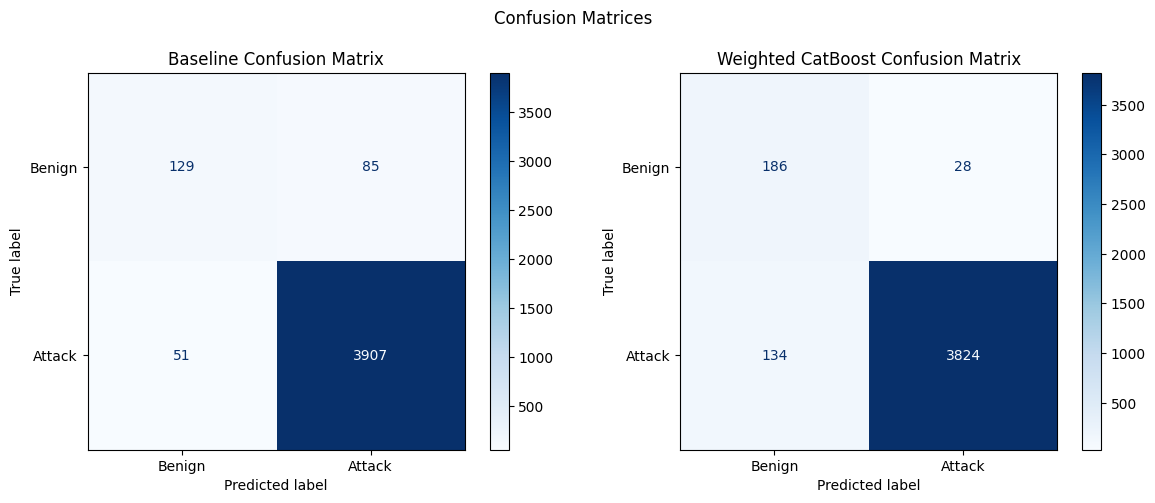

In [31]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

import matplotlib.pyplot as plt

# --- predicted probabilities for ROC ---
proba_base = baseline_model.predict_proba(X_test_base)[:, 1]
proba_weighted = ctb.predict_proba(X_test_base)[:, 1]

fpr_base, tpr_base, _ = roc_curve(y_test_base, proba_base)
fpr_w, tpr_w, _ = roc_curve(y_test_base, proba_weighted)
auc_base = auc(fpr_base, tpr_base)
auc_w = auc(fpr_w, tpr_w)

# Plot ROC curves
plt.figure(figsize=(7, 6))
plt.plot(fpr_base, tpr_base, label=f'Baseline (AUC={auc_base:.3f})', lw=2)
plt.plot(fpr_w, tpr_w, label=f'Weighted CatBoost (AUC={auc_w:.3f})', lw=2)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Baseline vs Weighted CatBoost')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# --- Confusion matrices ---
# Use existing predictions if available, else compute from models
pred_base = y_pred_base if 'y_pred_base' in globals() and y_pred_base is not None else baseline_model.predict(X_test_base)
pred_weighted = y_pred_base2 if 'y_pred_base2' in globals() and y_pred_base2 is not None else ctb.predict(X_test_base)

cm_base = confusion_matrix(y_test_base, pred_base)
cm_weighted = confusion_matrix(y_test_base, pred_weighted)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
labels = ['Benign', 'Attack']  # 0 -> Benign, 1 -> Attack

disp1 = ConfusionMatrixDisplay(cm_base, display_labels=labels)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Baseline Confusion Matrix')

disp2 = ConfusionMatrixDisplay(cm_weighted, display_labels=labels)
disp2.plot(ax=axes[1], cmap='Blues', values_format='d')
axes[1].set_title('Weighted CatBoost Confusion Matrix')

plt.suptitle('Confusion Matrices')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()